In [27]:
import talib
import pandas as pd
from pandas_datareader import data as pdr
import yfinance
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt

In [28]:
raw_df = pdr.get_data_yahoo("SPY")

In [29]:
df = raw_df.copy()
close = df["Adj Close"]

# 볼린저밴드
df["Upper"], df["Middle"], df["Lower"] = talib.BBANDS(close, timeperiod=20)

# 모멘텀
df["Momentum"] = talib.MOM(close, timeperiod=10)
df["Momentum_signal"] = talib.SMA(df["Momentum"], timeperiod=9)

# 이평선
df["MA5"] = talib.SMA(close, timeperiod=5)
df["MA15"] = talib.SMA(close, timeperiod=20)
df["MA20"] = talib.SMA(close, timeperiod=20)
df["MA60"] = talib.SMA(close, timeperiod=60)

# RSI
df["RSI"] = talib.RSI(close, timeperiod=14)
df["RSI_signal"] = talib.SMA(df["RSI"], timeperiod=6)

# MACD
df["MACD"], df["MACD_signal"], df["MACD_hist"] = talib.MACD(close)


In [30]:
temp_df = df.dropna()
temp_df = temp_df.reset_index()
temp_df["Score"] = 0
temp_dict = dict(temp_df)

for i in range(1, len(temp_dict["Close"])):
    # 주가가 밴드 상단보다 높으면 -1
    if temp_dict["Adj Close"][i] > temp_dict["Upper"][i]:
        temp_dict["Score"][i] -= 2
    # 주가가 밴드 하단보다 낮으면 +1
    elif temp_dict["Adj Close"][i] < temp_dict["Lower"][i]:
        temp_dict["Score"][i] += 2

    # 모멘텀이 0보다 위일 때 +1
    if temp_dict["Momentum"][i] > 0:
        temp_dict["Score"][i] += 1
    # 모멘텀이 0보다 아래일 때 -1
    elif temp_dict["Momentum"][i] < 0:
        temp_dict["Score"][i] -= 1

    # 모멘텀이 모멘텀 시그널을 상향돌파시 +1
    if (temp_dict["Momentum"][i-1] < temp_dict["Momentum_signal"][i-1]) and (temp_dict["Momentum_signal"][i] < temp_dict["Momentum"][i]):
        temp_dict["Score"][i] += 2
    # 모멘텀이 모멘텀 시그널을 하향돌파시 -1
    elif (temp_dict["Momentum"][i-1] > temp_dict["Momentum_signal"][i-1]) and (temp_dict["Momentum_signal"][i] > temp_dict["Momentum"][i]):
        temp_dict["Score"][i] -= 2

    # 단기 이평선이 장기 이평선을 상향돌파시 +1
    if (temp_dict["MA15"][i-1] < temp_dict["MA20"][i-1]) and (temp_dict["MA20"][i] < temp_dict["MA15"][i]):
        temp_dict["Score"][i] += 1
    # 단기 이평선이 장기 이평선을 하향돌파시 -1
    elif (temp_dict["MA15"][i-1] > temp_dict["MA20"][i-1]) and (temp_dict["MA20"][i] > temp_dict["MA15"][i]):
        temp_dict["Score"][i] -= 1

    # RSI가 70을 넘어가면 과매수 -1
    if temp_dict["RSI"][i] >= 70:
        temp_dict["Score"][i] -= 2
    # RSI가 30에서 내려가면 과매도 +1
    elif temp_dict["RSI"][i] <= 30:
        temp_dict["Score"][i] += 2

    # RSI가 RSI 시그널을 상향돌파시 +1
    if (temp_dict["RSI"][i-1] < temp_dict["RSI_signal"][i-1]) and (temp_dict["RSI_signal"][i] < temp_dict["RSI"][i]):
        temp_dict["Score"][i] += 1
    # RSI가 RSI 시그널을 하향돌파시 -1
    elif (temp_dict["RSI"][i-1] > temp_dict["RSI_signal"][i-1]) and (temp_dict["RSI_signal"][i] > temp_dict["RSI"][i]):
        temp_dict["Score"][i] -= 1

    # MACD가 MACD 시그널을 상향돌파시 +1
    if (temp_dict["MACD"][i-1] < temp_dict["MACD_signal"][i-1]) and (temp_dict["MACD_signal"][i] < temp_dict["MACD"][i]):
        temp_dict["Score"][i] += 1
    # MACD가 MACD 시그널을 하향돌파시 -1
    elif (temp_dict["MACD"][i-1] > temp_dict["MACD_signal"][i-1]) and (temp_dict["MACD_signal"][i] > temp_dict["MACD"][i]):
        temp_dict["Score"][i] -= 1

temp_df = pd.DataFrame.from_dict(temp_dict)

C:\Users\love9\anaconda3\envs\data\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\love9\anaconda3\envs\data\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\love9\anaconda3\envs\data\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\love9\anaconda3\envs\data\lib\sit

In [31]:
seed = 1000000
buy_price = 0
holding = False
fee = 0.0016
buy_threshold = 3
sell_threshold = -4

#df.drop("index", inplace=True, axis=1)
df = temp_df.copy()
for index, row in df.iterrows():
    df.loc[index, "yield"] = int((seed/1000000-1)*100)
    if row["Score"] >= buy_threshold:
        if not holding:
            buy_price = row["Adj Close"]
            print(f"{row['Date']} buy :", buy_price)
            df.loc[index, "trade"] = "BUY"
            holding = True

    elif row["Score"] <= sell_threshold:
        if holding:
            sell_price = row["Adj Close"]
            print(f"{row['Date']} sell :", sell_price)
            print(f"수익률 : {round(((sell_price/buy_price) * (1-fee) - 1)*100, 2)}%")
            holding = False
            df.loc[index, "trade"] = "SELL"
            seed = seed * (sell_price/buy_price) * (1-fee)

            print(f"총수익률 : {round((seed/1000000-1)*100, 2)}%")
            print("===================")

    # 5%이상 손실날 때 손절
    elif holding and row["Adj Close"]/buy_price <= 0.9:
            sell_price = row["Adj Close"]
            print(f"{row['Date']} sell :", sell_price)
            print(f"손실률 : {round(((sell_price/buy_price) * (1-fee) - 1)*100, 2)}%")
            holding = False
            df.loc[index, "trade"] = "STOP"
            seed = seed * (sell_price/buy_price) * (1-fee)

            print(f"총수익률 : {round((seed/1000000-1)*100, 2)}%")
            print("===================")

    # 10% 이상 수익날 때 익절
    # elif holding and row["Adj Close"]/buy_price >= 1.1:
    #     sell_price = row["Adj Close"]
    #     print(f"{row['Date']} sell :", sell_price)
    #     holding = False
    #     seed = seed * (sell_price/buy_price) * (1-fee)

print(seed)
print(f"총수익률 : {round((seed/1000000-1)*100, 2)}%")
df["buynhold"] = round(((1000000/df.iloc[0]["Adj Close"]*df["Adj Close"])/1000000-1)*100, 2)
print(f"바이앤홀드 수익률 : {df.iloc[-1]['buynhold']}%", )

2017-11-21 00:00:00 buy : 242.96815490722656
2018-01-29 00:00:00 sell : 267.4015808105469
수익률 : 9.88%
총수익률 : 9.88%
2018-02-05 00:00:00 buy : 247.9109649658203
2019-08-14 00:00:00 sell : 274.25860595703125
수익률 : 10.45%
총수익률 : 21.36%
2019-08-28 00:00:00 buy : 279.07916259765625
2019-12-02 00:00:00 sell : 302.44683837890625
수익률 : 8.2%
총수익률 : 31.32%
2019-12-06 00:00:00 buy : 305.5815124511719
2020-03-09 00:00:00 sell : 267.44891357421875
손실률 : -12.62%
총수익률 : 14.74%
2020-03-12 00:00:00 buy : 241.9747772216797
2021-01-04 00:00:00 sell : 366.38739013671875
수익률 : 51.17%
총수익률 : 73.46%
2021-01-06 00:00:00 buy : 371.11639404296875
2021-09-28 00:00:00 sell : 433.7200012207031
수익률 : 16.68%
총수익률 : 102.4%
2021-11-24 00:00:00 buy : 469.44000244140625
2022-02-23 00:00:00 sell : 421.95001220703125
손실률 : -10.26%
총수익률 : 81.63%
2022-03-09 00:00:00 buy : 427.4100036621094
2022-03-11 00:00:00 sell : 420.07000732421875
수익률 : -1.87%
총수익률 : 78.23%
2022-07-15 00:00:00 buy : 385.1300048828125
1782291.5690967871
총

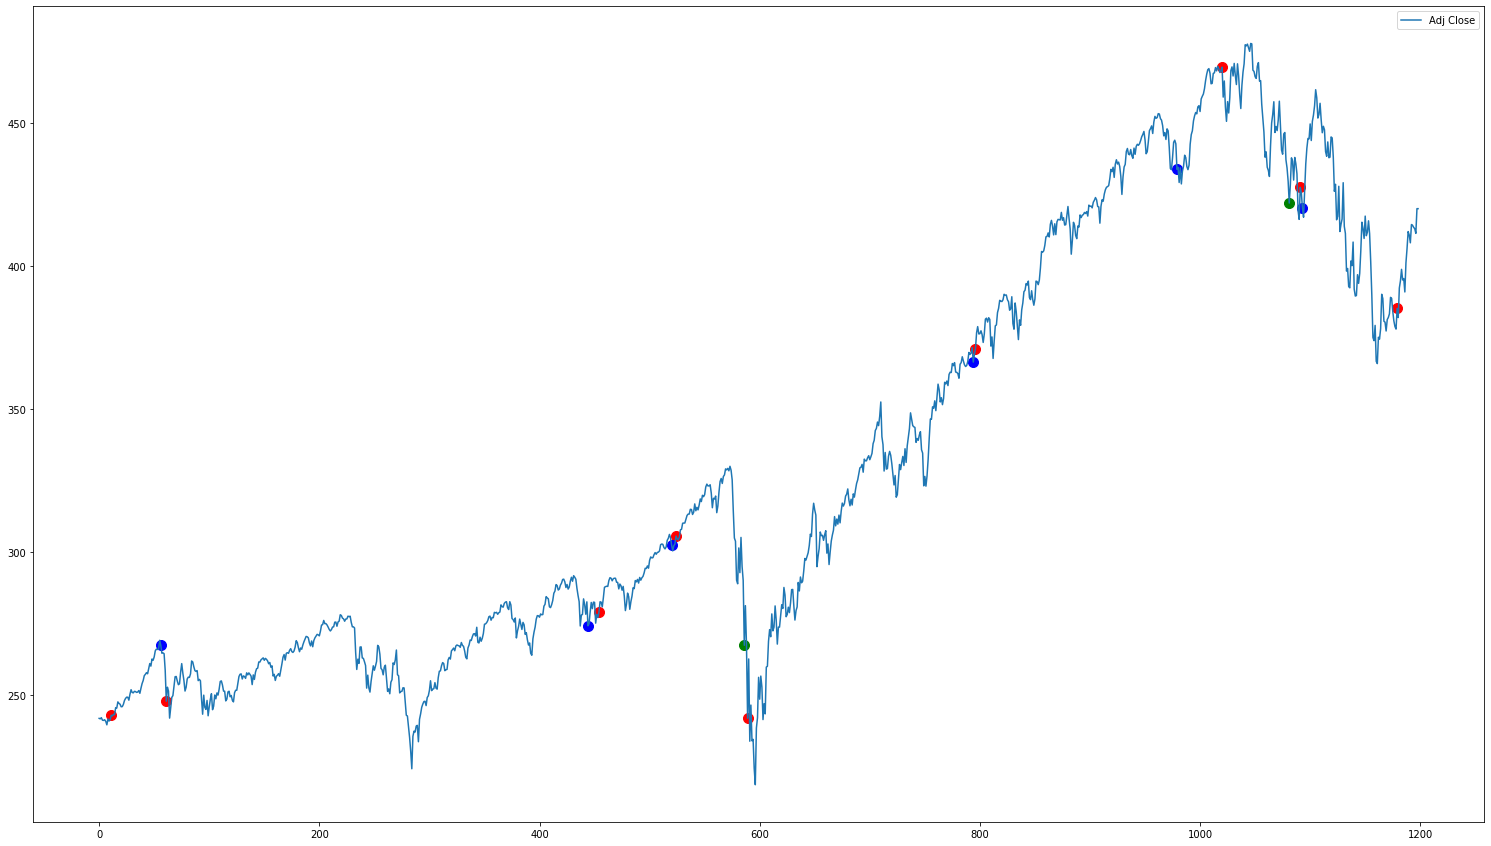

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(26, 15))
plt.scatter(df[df["trade"]=="BUY"]["Adj Close"].reset_index()["index"], df[df["trade"]=="BUY"]["Adj Close"], color="red", s=100)
plt.scatter(df[df["trade"]=="SELL"]["Adj Close"].reset_index()["index"], df[df["trade"]=="SELL"]["Adj Close"], color="blue", s=100)
plt.scatter(df[df["trade"]=="STOP"]["Adj Close"].reset_index()["index"], df[df["trade"]=="STOP"]["Adj Close"], color="green", s=100)
plt.plot(df["Adj Close"], label="Adj Close")
plt.legend()